## MTH9899 Machine Learning 
### Assignment 2
#### Name: ShengQuan Zhou

### Problem 1

In class, we spoke about the equation below
$$
\sigma^2(\bar{\hat{y}}) = \rho \sigma_{\hat{y}_i}^2 + \frac{1-\rho}{B}\sigma_{\hat{y}_i}^2,
$$
where $\rho$ represents the correlation between any two predictors and $B$ represents
the number of predictors. This is a description of how the variance of the average of identically distributed variables decreases as we add more predictors to an ensemble. Please derive this formula - you can ignore the case of negative correlations.

#### Solution:

The sample mean $\bar{\hat{y}} = \frac{1}{B}\sum_{i=1}^B \hat{y}_i$.

The variance of the sample mean
\begin{align}
\sigma^2(\bar{\hat{y}}) &\triangleq \text{Var}\left( \frac{1}{B}\sum _ {i=1}^B \hat{y} _ i \right) \\
&= \frac{1}{B^2}\text{Var}\left( \sum _ {i=1}^B \hat{y} _ i \right) \\
&= \frac{1}{B^2}\left( \mathbb{E}\left[\left( \sum _ {i=1}^B \hat{y} _ i \right)^2\right] - \mathbb{E}\left[ \sum _ {i=1}^B \hat{y} _ i\right]^2 \right)\\
&= \frac{1}{B^2}\left( \sum _ {i=1}^B\sum _ {j=1}^B\mathbb{E}\left[\hat{y} _ i\hat{y} _ j\right] - \sum _ {i=1}^B\sum _ {j=1}^B\mathbb{E}\left[\hat{y} _ i\right]\mathbb{E}\left[\hat{y} _ j\right] \right)\\
&= \frac{1}{B^2} \sum _ {i=1}^B\sum _ {j=1}^B \left(\mathbb{E}\left[\hat{y} _ i\hat{y} _ j\right] - \mathbb{E}\left[\hat{y} _ i\right]\mathbb{E}\left[\hat{y} _ j\right] \right)\\
&= \frac{1}{B^2} \left[ \sum _ {i=1}^B \text{Var}(\hat{y} _ i^2) + \sum _ {i\neq j =1}^B \text{Cov}(\hat{y} _ i, \hat{y} _ j)\right]\\
&= \frac{1}{B^2} \left[ \sum _ {i=1}^B \text{Var}(\hat{y} _ i^2) + \sum _ {i\neq j =1}^B \text{Cov}(\hat{y} _ i, \hat{y} _ j)\right]\\
&= \frac{1}{B^2} \left[ B\sigma _ {\hat{y} _ i}^2 + (B^2-B) \rho \sigma _ {\hat{y} _ i}^2\right]\\
&= \rho \sigma _ {\hat{y} _ i}^2 + \frac{1-\rho}{B}\sigma _ {\hat{y} _ i}^2.
\end{align}

#### Note

See Professor Andrew Lesniewsky's Lecture 8 (Counterparty Credit Risk) in Credit Risk Models for an application of the above trick to the impact of netting and correlations.

### Problem 2

Implement a simple regression tree. We will use point estimates in the leaves
and use the CART Variance Reduction measure for a splitting criteria
$$
VR(S) = \text{var}S - \sum_{i=0}^K \frac{|S_i|}{|S|}\text{var}S_i.
$$
For simplicity’s sake, divide each attribute up into 5 equal sized bins, and test each
end point of a bin as a potential split point.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def generate_test_data(N, noise=100):
    x = np.random.randn(N, 5)
    y = np.where(x[:, 0] > 0, 2, 5)
    y = y + np.where(x[:, 1] > 0, -3, 3)
    y = y + np.where(x[:, 2] > 0, 0, 0.5)
    y = y + np.random.randn(N)*noise
    return x,y

class TreeNode:
    def predict(x, y):
        assert False

    def depth(self):
        assert False

class BranchNode(TreeNode):
    def __init__(self, left, right, split_var_index, split_var_value):
        self.left = left
        self.right = right
        self.split_var_index = split_var_index
        self.split_var_value = split_var_value

    def predict(self, x):
        svar = x[:, self.split_var_index]
        is_left = svar < self.split_var_value
        leftx = x[is_left]
        rightx = x[~is_left]

        rv = np.zeros(x.shape[0])
        rv[is_left] = self.left.predict(leftx)
        rv[~is_left] = self.right.predict(rightx)

        return rv

    def depth(self):
        return 1 + max(self.left.depth(), self.right.depth())

class LeafNode(TreeNode):
    def __init__(self, mu):
        self.mu = mu

    def predict(self, x):
        return np.repeat(self.mu, x.shape[0])

    def depth(self):
        return 1

class RegressionTree:
    def __init__(self, max_depth, min_points_in_leaf, num_cv_folds=1):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf
        self.num_cv_folds = num_cv_folds

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)
    
    def compute_cv_variance(self, y):
        fold_size = int(len(y)/self.num_cv_folds)
        var = 0
        for k in range(self.num_cv_folds):
            test = y[k*fold_size : (k+1)*fold_size]
            train = np.concatenate([y[0:k*fold_size], y[(k+1)*fold_size:len(y)]])
            train_mean = np.mean(train)
            test_demean = test - train_mean
            test_var = np.sum(test_demean*test_demean)/len(test_demean)
            var += test_var
        var /= self.num_cv_folds
        return var

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)

    def fit_internal(self, x, y, current_depth):
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        best_split = None
        best_leftx = None
        best_lefty = None
        best_rightx = None
        best_righty = None

        # Here, we have to loop over all features and figure out which one
        # might be splittable, and if it is, how to split it to maximize Variance Reduction
        max_var_reduction = 0
        for i in range(num_features):
            split_var_index = i
            split_var_values = np.percentile(x[:,i], [20,40,60,80])
            for split_var_value in split_var_values:
                svar = x[:, split_var_index]
                is_left = svar < split_var_value
                lefty = y[is_left]
                righty = y[~is_left]

                if len(lefty) <= self.min_points_in_leaf or len(righty) <= self.min_points_in_leaf:
                    continue

                var_lefty = 0
                var_righty = 0
                var_reduction = var_orig
                if self.num_cv_folds > 1:
                    var_lefty = self.compute_cv_variance(lefty)
                    var_righty = self.compute_cv_variance(righty)
                else:
                    var_lefty = np.var(lefty)
                    var_righty = np.var(righty)
                    
                var_reduction -= var_lefty*len(lefty)/len(y)
                var_reduction -= var_righty*len(righty)/len(y)

                if var_reduction > max_var_reduction:
                    best_variable = split_var_index
                    best_split = split_var_value
                    best_leftx = x[is_left]
                    best_lefty = y[is_left]
                    best_rightx = x[~is_left]
                    best_righty = y[~is_left]
                    max_var_reduction = var_reduction
        

        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            left_tree = self.fit_internal(best_leftx, best_lefty, current_depth+1)
            right_tree = self.fit_internal(best_rightx, best_righty, current_depth+1)
            return BranchNode(left_tree, right_tree, best_variable, best_split)


    def depth(self):
        return self.root.depth()

#### Part I.

Test your algorithm on a 50000 row dataset generated using the attached generate test data function. Test against different max depths and report a graph of depth vs $R^2$ . Now, on the same graph, plot $R^2$ where you are using a new dataset, generated independently of the one used to train the tree. Does it look different? Why?

In [48]:
def run_test(X_train, Y_train, X_test, Y_test, num_obs, max_depth, min_points_in_leaf, num_cv_folds=1):
    """
        Parameters
        ----------
        X_train: X of training data set
        Y_train: Y of training data set
        X_test: X of test data set
        Y_test: Y of test data set
        num_obs: number of instances of observations (data points);
        max_depth: maximum tree depths to test;
        min_points_in_leaf: minimum number of data points in leaf node;
        num_cv_folds: number of cross validation folds.
        
        Returns
        ----------
        depth_list: list of max tree depths
        r2_fit_list: list of R2 for in-sample fit
        r2_predict_list: list of R2 for out-of-sample prediction
    """

    depth_list = []
    r2_fit_list = []
    r2_predict_list = []
    for i in range(max_depth):
        # fit
        regression_tree = RegressionTree(i+1, min_points_in_leaf, num_cv_folds)
        regression_tree.fit(X_train, Y_train)
        
        # in-sample fit
        Y_fit = regression_tree.predict(X_train)
        # out-of-sample prediction
        Y_predict = regression_tree.predict(X_test)

        # R2 for in-sample fit
        var_y_train = np.var(Y_train)
        var_residual_fit = np.var(Y_train - Y_fit)
        r2_fit = 1 - var_residual_fit/var_y_train

        # R2 for out-of-sample prediction
        var_y_test = np.var(Y_test)
        var_residual_predict = np.var(Y_test - Y_predict)
        r2_predict = 1 - var_residual_predict/var_y_test
    
        depth_list.append(i+1)
        r2_fit_list.append(r2_fit)
        r2_predict_list.append(r2_predict)
        
    return (depth_list, r2_fit_list, r2_predict_list)

In [49]:
# parameters
num_obs = 50000
max_depth = 20
min_points_in_leaf = 100

noise = 10
X_train_low_noise, Y_train_low_noise = generate_test_data(num_obs, noise)
X_test_low_noise, Y_test_low_noise = generate_test_data(num_obs, noise)

noise = 100
X_train_high_noise, Y_train_high_noise = generate_test_data(num_obs, noise)
X_test_high_noise, Y_test_high_noise = generate_test_data(num_obs, noise)

In [50]:
# lower noise level
depth_list_1, r2_fit_list_1, r2_predict_list_1 = run_test(X_train_low_noise, Y_train_low_noise, X_test_low_noise, Y_test_low_noise, num_obs, max_depth, min_points_in_leaf)

# higher noise level
depth_list_2, r2_fit_list_2, r2_predict_list_2 = run_test(X_train_high_noise, Y_train_high_noise, X_test_high_noise, Y_test_high_noise, num_obs, max_depth, min_points_in_leaf)

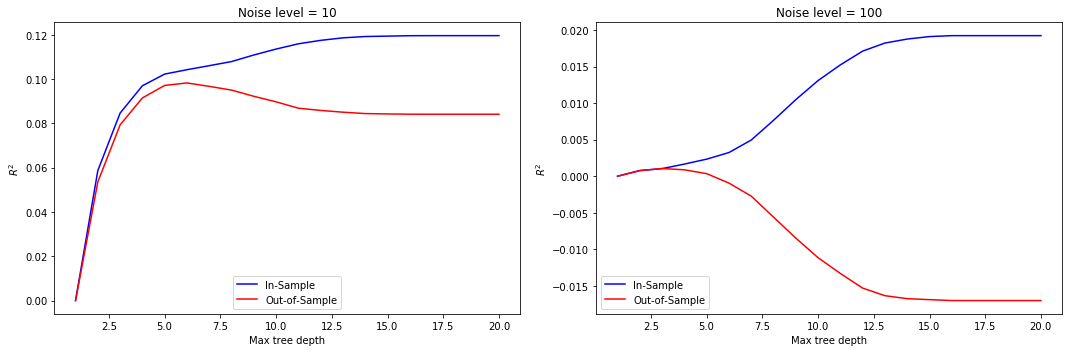

In [51]:
# plot R^2 as a function of max tree depth
fig, axarr = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

axarr[0].plot(depth_list_1, r2_fit_list_1, 'b-', label='In-Sample')
axarr[0].plot(depth_list_1, r2_predict_list_1, 'r-', label='Out-of-Sample')
axarr[0].set_title('Noise level = 10')
axarr[0].set_xlabel('Max tree depth')
axarr[0].set_ylabel('$R^2$')
legend = axarr[0].legend(loc='lower center', shadow=False)

axarr[1].plot(depth_list_2, r2_fit_list_2, 'b-', label='In-Sample')
axarr[1].plot(depth_list_2, r2_predict_list_2, 'r-', label='Out-of-Sample')
axarr[1].set_title('Noise level = 100')
axarr[1].set_xlabel('Max tree depth')
axarr[1].set_ylabel('$R^2$')
legend = axarr[1].legend(loc='lower left', shadow=False)

plt.tight_layout()
plt.show()

#### Comment

The dependence of $R^2$ on the max tree depth looks different for in-sample fit and out-of-sample prediction. In both cases for noise level 10 and 100, the out-of-sample $R^2$ starts to decline at about depth $\approx 5$. For higher noise level, the out-of-sample $R^2$ drops negative as the tree grows deeper. This is the phenomenon of overfitting.

### Part II.

One way to potentially improve this and avoid overfitting would be to use cross-validation when calculating variance reduction. Modify your tree to have the constructor to take a num CV folds parameter. If this value is > 1, then calculate the variance reduction on a cross-validated dataset instead, i.e. for each candidate split point you are considering, you should do a CV measurement of the variance reduction. ONLY SPLIT if the CV Variance Reduction is positive. Repeat the experiments from the first part of the question and discuss any differences.

In [52]:
# parameters
num_cv_folds = 5

# lower noise level
depth_list_3, r2_fit_list_3, r2_predict_list_3 = run_test(X_train_low_noise, Y_train_low_noise, X_test_low_noise, Y_test_low_noise, num_obs, max_depth, min_points_in_leaf, num_cv_folds)

# higher noise level
depth_list_4, r2_fit_list_4, r2_predict_list_4 = run_test(X_train_high_noise, Y_train_high_noise, X_test_high_noise, Y_test_high_noise, num_obs, max_depth, min_points_in_leaf, num_cv_folds)

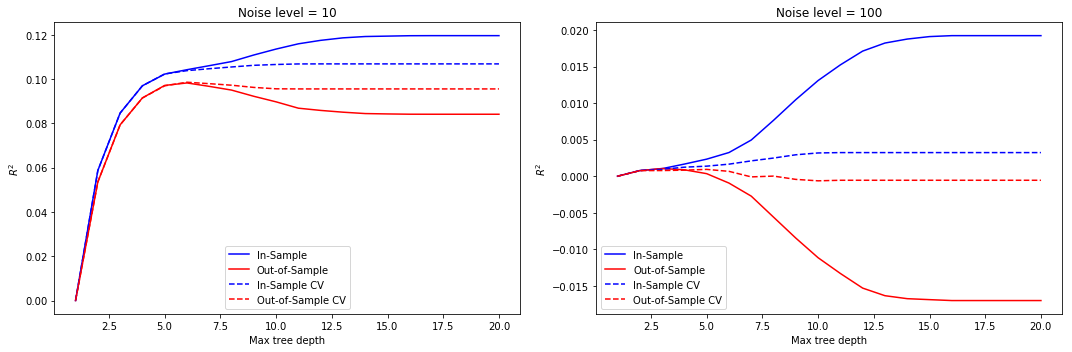

In [53]:
# plot R^2 as a function of max tree depth
fig, axarr = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

axarr[0].plot(depth_list_1, r2_fit_list_1, 'b-', label='In-Sample')
axarr[0].plot(depth_list_1, r2_predict_list_1, 'r-', label='Out-of-Sample')
axarr[0].plot(depth_list_3, r2_fit_list_3, 'b--', label='In-Sample CV')
axarr[0].plot(depth_list_3, r2_predict_list_3, 'r--', label='Out-of-Sample CV')
axarr[0].set_title('Noise level = 10')
axarr[0].set_xlabel('Max tree depth')
axarr[0].set_ylabel('$R^2$')
legend = axarr[0].legend(loc='lower center', shadow=False)

axarr[1].plot(depth_list_2, r2_fit_list_2, 'b-', label='In-Sample')
axarr[1].plot(depth_list_2, r2_predict_list_2, 'r-', label='Out-of-Sample')
axarr[1].plot(depth_list_4, r2_fit_list_4, 'b--', label='In-Sample CV')
axarr[1].plot(depth_list_4, r2_predict_list_4, 'r--', label='Out-of-Sample CV')
axarr[1].set_title('Noise level = 100')
axarr[1].set_xlabel('Max tree depth')
axarr[1].set_ylabel('$R^2$')
legend = axarr[1].legend(loc='lower left', shadow=False)

plt.tight_layout()
plt.show()

#### Comment

Cross Validation alleviates the problem of over-fitting, as shown in the above charts.